# Dati Covid-19

In [1]:
import sys, glob
import pandas as pd
import numpy as np
from miscellanea import adatta_nome, importa_abitanti, importa_dati_giornalieri, date_mancanti
from miscellanea import importa_dati_italia, importa_dati_emr, importa_dati_prov

### Dati nazionali, regionali, provinciali

Fonte dati: [Presidenza del Consiglio dei Ministri - Dipartimento della Protezione Civile](https://github.com/pcm-dpc)

Import dati nazionali e regionali

In [2]:
dataset = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv'
ita = importa_dati_italia(dataset)
ita_abitanti = 59_641_488 # Fonte https://www.tuttitalia.it/regioni/popolazione/

emr = importa_dati_emr(dataset)
emr_abitanti = 4_464_119 # Fonte https://www.tuttitalia.it/regioni/popolazione/

Import dati provinciali

In [3]:
dataset = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-province/dpc-covid19-ita-province.csv'

mo = importa_dati_prov(dataset)
mo_abitanti = 707_119 # Fonte https://www.tuttitalia.it/emilia-romagna/provincia-di-modena/

### Dati provincia di Modena - dettaglio comune per comune

Fonte: nuovi positivi comune per comune dal report dell'AUSL di Modena (letti sulle pagine di [sulpanaro.net](https://www.sulpanaro.net/)).

I dati vegono importati da `salva_report.py` e salvati nella cartella report_vari: 

In [4]:
dfcomuni = pd.read_csv('report_vari/nuovi_positivi_comuni_MO.csv', index_col=0, parse_dates=True)

Abitanti dei comuni nella provincia di Modena da [qui](https://www.tuttitalia.it/emilia-romagna/provincia-di-modena/70-comuni/popolazione/) (aggiornato a 31/12/2019 - dati ISTAT)

In [5]:
abitanti = importa_abitanti('abitanti_provincia_di_Modena.txt')

Aggiungi al dizionario `abitanti` quelli di provincia, regione, nazione

In [6]:
abitanti['Emilia Romagna'] = emr_abitanti
abitanti['Italia'] = ita_abitanti
abitanti['Provincia MO'] = mo_abitanti

Crea le varie timeline di incidenza 7gg.

In [7]:
roll = dfcomuni.rolling(7, center=False).sum()
ita_roll = ita.rolling(7, center=False).sum()
emr_roll = emr.rolling(7, center=False).sum()
mo_roll = mo.rolling(7, center=False).sum()

## Grafici

### Nonantola

Lista comuni di confronto (tutti quelli con > 10mila abitanti)

In [8]:
lista_comuni = [ k for k,v in abitanti.items() if (v>10000) & (k not in ['Emilia Romagna', 'Provincia MO', 'Italia', 'Nonantola']) ]

In [13]:
range_temporale = '2021-07-10'

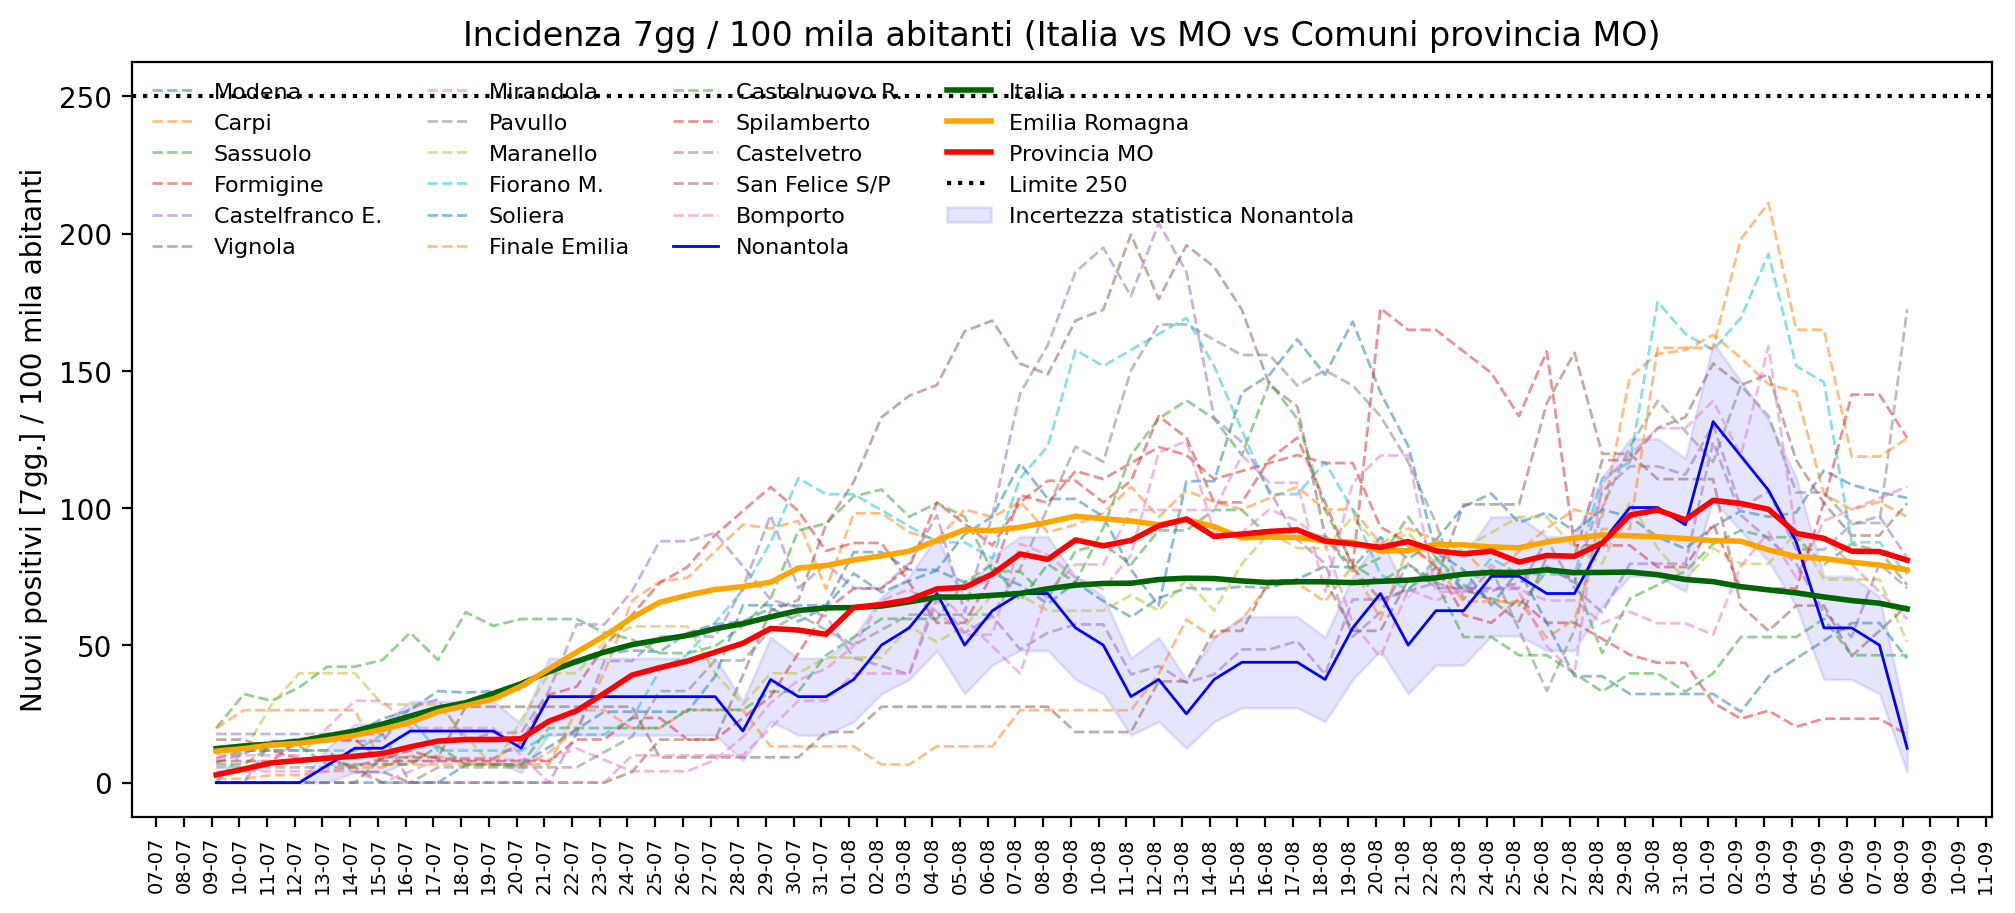

In [14]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

#plt.style.use('dark_background')
plt.style.use('fast')
# plt.style.use('fivethirtyeight')
# plt.style.use('seaborn-deep')
# plt.style.use('seaborn-dark-palette')

fig, ax = plt.subplots(figsize=(12,5), dpi=200)

xfmt = mdates.DateFormatter('%d-%m')
xloc = mdates.HourLocator(interval=24*1)
ax.xaxis.set_major_formatter(xfmt)
ax.xaxis.set_major_locator(xloc)
ax.tick_params(axis='x', rotation=90, labelsize=7)
# ax.tick.label.set_fontsize('x-small')

ax.set_title('Incidenza 7gg / 100 mila abitanti (Italia vs MO vs Comuni provincia MO)')
ax.set_ylabel('Nuovi positivi [7gg.] / 100 mila abitanti')

for k in lista_comuni:
    toplot = roll[k]/abitanti[k]*100000
    ax.plot(toplot[range_temporale:], 
            linestyle='--',
#              drawstyle='steps',
            alpha=0.5, lw=1, label=k
           )
    
# Nonantola
toplot = roll['Nonantola']/abitanti['Nonantola']*100000
ax.plot(toplot[range_temporale:], alpha=1, lw=1, color='blue', label='Nonantola')

# # Soliera
# toplot = roll['Soliera']/abitanti['Soliera']*100000
# ax.plot(toplot[range_temporale:], alpha=1, lw=3, color='Magenta', label='Soliera')

# Nonantola, banda incert. statistica    
toplot_inf = (roll['Nonantola'] - np.sqrt(roll['Nonantola'])) / abitanti['Nonantola']*100000
toplot_sup = (roll['Nonantola'] + np.sqrt(roll['Nonantola'])) / abitanti['Nonantola']*100000
ax.fill_between(toplot_inf[range_temporale:].index, 
                toplot_sup[range_temporale:],
                toplot_inf[range_temporale:],
                alpha=0.1, color='blue',
               label='Incertezza statistica Nonantola')

## Nazione, Regione, Provincia
toplot = ita_roll/abitanti['Italia']*100000
ax.plot(toplot[range_temporale:], alpha=1, lw=2, color='darkgreen', label='Italia')
toplot = emr_roll/abitanti['Emilia Romagna']*100000
ax.plot(toplot[range_temporale:], alpha=1, lw=2, color='orange', label='Emilia Romagna')
toplot = mo_roll/abitanti['Provincia MO']*100000
ax.plot(toplot[range_temporale:], alpha=1, lw=2, color='red', label='Provincia MO')

# linea 250
ax.axhline(250, linestyle=':', c='k', label='Limite 250')

plt.legend(ncol=4, fontsize=8, frameon=False)
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1, fontsize=8)

plt.show()
fig.set_facecolor('white')
fig.savefig('Nonantola.png')
fig.savefig('Nonantola.pdf')

Dettaglio di un dato giorno

In [16]:
giorno='2021-09-09'
titolo = pd.to_datetime(giorno)

dettaglio={}
for k in lista_comuni:
    toplot = roll[k]/abitanti[k]*100000
    dettaglio[k] = toplot[giorno]

# highlight colorato Nonantola
# "\x1b[46m\"cyan bkg\"\x1b[0m"
openingseq = {c:'\x1b[0m' for c in lista_comuni}
closiningseq = '\x1b[0m'
openingseq['Nonantola'] = '\x1b[1;46m'

ultimo = [(k,v) for k,v in dettaglio.items()]
ultimo.append(('Nonantola', (roll['Nonantola']/abitanti['Nonantola']*100000)[giorno]))
ultimo.sort(key=lambda x:x[1])
print(f"# Giorno: \x1b[46m{titolo:%d-%m-%Y}\x1b[0m")
sottotitolo='# nr, comune, incid7gg/100mila ab.'
print(sottotitolo)
print('-'*len(sottotitolo))
for i,e in enumerate(ultimo[::-1]):
    print(f'{openingseq[e[0]]}{i+1}\t{e[0]:20}{e[1]:.1f}{closiningseq}')

# Giorno: 09-09-2021
# nr, comune, incid7gg/100mila ab.
----------------------------------
1	Pavullo             172.4
2	Spilamberto         125.6
3	Finale Emilia       125.4
4	Mirandola           107.8
5	Modena              103.7
6	Vignola             101.8
7	Carpi               96.7
8	Castelfranco E.     81.9
9	Fiorano M.          75.9
10	Sassuolo            72.0
11	Castelvetro         70.9
12	San Felice S/P      64.5
13	Bomporto            59.6
14	Maranello           51.2
15	Castelnuovo R.      46.4
16	Soliera             45.2
17	Formigine           17.5
18	Nonantola           12.5


In [23]:
emr_roll/abitanti['Emilia Romagna']*100000, mo_roll/abitanti['Provincia MO']*100000

(data
 2020-02-24          NaN
 2020-02-25          NaN
 2020-02-26          NaN
 2020-02-27          NaN
 2020-02-28          NaN
                 ...    
 2021-08-05    88.236895
 2021-08-06    92.112240
 2021-08-07    91.776227
 2021-08-08    93.008273
 2021-08-09    94.845142
 Length: 533, dtype: float64, data
 2020-02-24          NaN
 2020-02-25          NaN
 2020-02-26          NaN
 2020-02-27          NaN
 2020-02-28          NaN
                 ...    
 2021-08-05    70.568037
 2021-08-06    71.133713
 2021-08-07    75.941956
 2021-08-08    83.295739
 2021-08-09    81.315875
 Length: 533, dtype: float64)

## Superamenti 250/100mila

Comuni fra 10mila e 20mila abitanti

Attraversamenti soglia 250/100mila

In [24]:
cross = {} # dict con serie dei crossing points
for c in lista_comuni:
    s = roll[c]/abitanti[c]*100_000
    crossings = (s>250) & (s.shift(1)<250) 
    cross[c] = s[crossings][range_temporale:]

Elenco superamenti

In [25]:
for c in lista_comuni:
    print('-'*40)
    print(f'Comune: {c} (ab. {abitanti[c]})')
    print(f'Superamenti: {len(cross[c])}')
    print('-'*40)
    for el in cross[c].iteritems():
        print(f'\t{el[0].date()}: {el[1]:.1f}')
   

----------------------------------------
Comune: Modena (ab. 189013)
Superamenti: 0
----------------------------------------
----------------------------------------
Comune: Carpi (ab. 72369)
Superamenti: 0
----------------------------------------
----------------------------------------
Comune: Sassuolo (ab. 40278)
Superamenti: 0
----------------------------------------
----------------------------------------
Comune: Formigine (ab. 34366)
Superamenti: 0
----------------------------------------
----------------------------------------
Comune: Castelfranco E. (ab. 32983)
Superamenti: 0
----------------------------------------
----------------------------------------
Comune: Vignola (ab. 25549)
Superamenti: 0
----------------------------------------
----------------------------------------
Comune: Mirandola (ab. 24122)
Superamenti: 0
----------------------------------------
----------------------------------------
Comune: Pavullo (ab. 17978)
Superamenti: 1
------------------------------